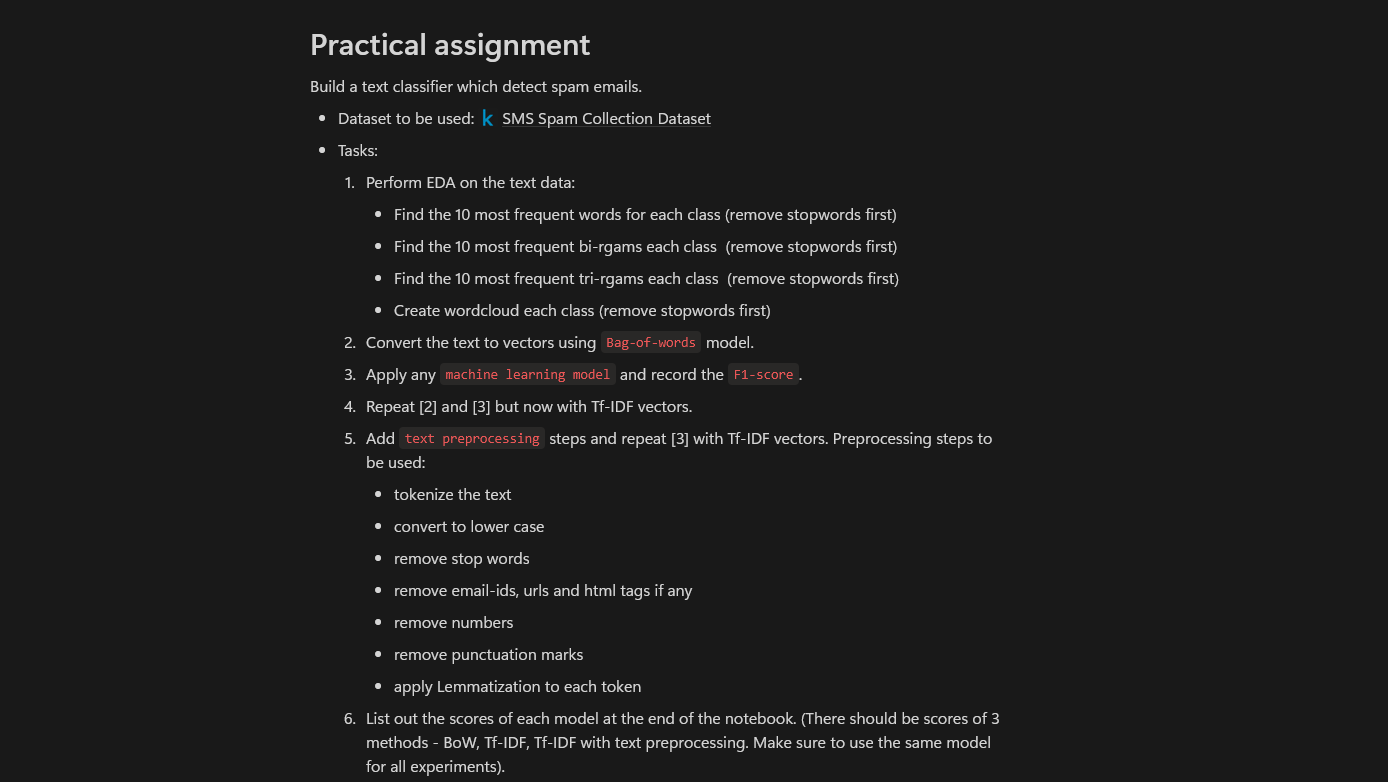

### Necessary installations

In [1]:
!pip install pandas scikit-learn nltk wordcloud matplotlib

In [2]:
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\laava\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\laava\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\laava\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

### 1. EDA

Top 10 most frequent words in Ham messages:
[(('u',), 988), (('im',), 461), (('get',), 307), (('ltgt',), 276), (('ok',), 272), (('dont',), 268), (('go',), 249), (('ur',), 240), (('ill',), 240), (('got',), 232)]

Top 10 most frequent words in Spam messages:
[(('call',), 350), (('free',), 219), (('u',), 155), (('txt',), 151), (('ur',), 144), (('mobile',), 124), (('text',), 121), (('stop',), 116), (('claim',), 113), (('reply',), 101)]

Top 10 most frequent bigrams in Ham messages:
[(('call', 'later'), 50), (('ill', 'call'), 48), (('let', 'know'), 39), (('sorry', 'ill'), 39), (('r', 'u'), 37), (('u', 'r'), 37), (('dont', 'know'), 33), (('good', 'morning'), 30), (('im', 'going'), 26), (('take', 'care'), 24)]

Top 10 most frequent bigrams in Spam messages:
[(('please', 'call'), 46), (('po', 'box'), 28), (('p', 'per'), 25), (('contact', 'u'), 24), (('guaranteed', 'call'), 23), (('call', 'landline'), 23), (('prize', 'guaranteed'), 22), (('selected', 'receive'), 19), (('send', 'stop'), 19), (('

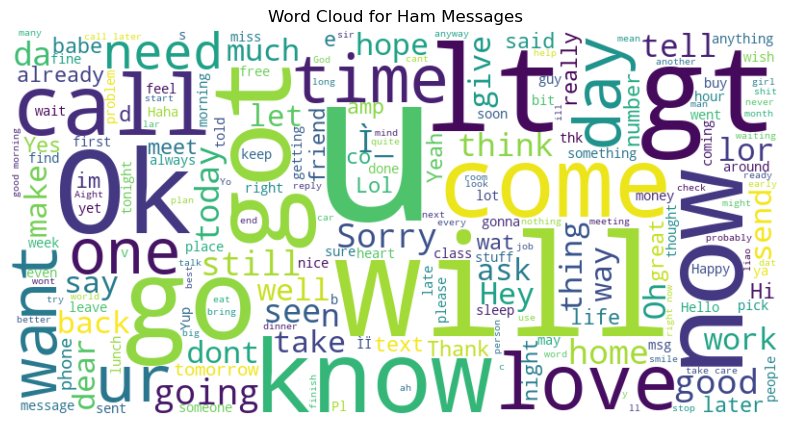

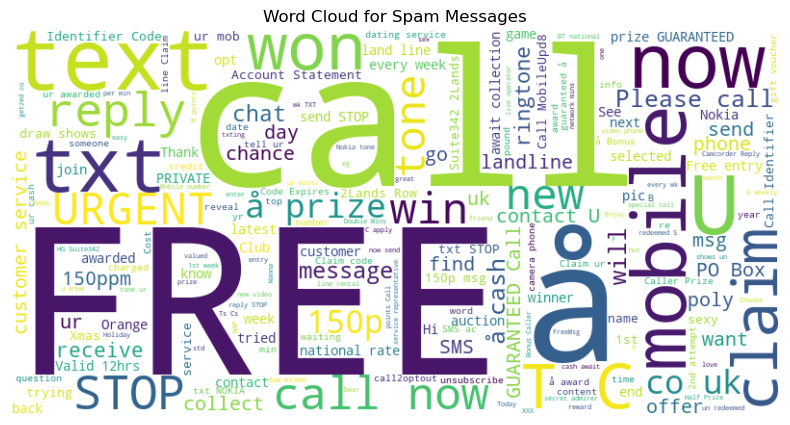

In [3]:
import pandas as pd
from collections import Counter
import re
from nltk.corpus import stopwords
from nltk.util import ngrams
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Load the dataset
df = pd.read_csv('spam.csv', encoding='latin-1')

# Rename columns for clarity
df = df.rename(columns={'v1': 'label', 'v2': 'text'})
df = df.drop(columns=['Unnamed: 2', 'Unnamed: 3', 'Unnamed: 4'], axis=1)

# Map labels to 0 and 1 for convenience
df['label'] = df['label'].map({'ham': 0, 'spam': 1})

# Separate ham and spam messages
ham_text = ' '.join(df[df['label'] == 0]['text'])
spam_text = ' '.join(df[df['label'] == 1]['text'])

# Define a function to get top N grams
def get_top_ngrams(text, n=1, top_n=10):
    stop_words = set(stopwords.words('english'))
    text = re.sub(r'[^a-zA-Z\s]', '', text)  # Remove punctuation and numbers
    tokens = [word.lower() for word in text.split() if word.lower() not in stop_words]
    
    n_grams = ngrams(tokens, n)
    counts = Counter(n_grams)
    return counts.most_common(top_n)

# Find top 10 most frequent words (unigrams)
print("Top 10 most frequent words in Ham messages:")
print(get_top_ngrams(ham_text, n=1))
print("\nTop 10 most frequent words in Spam messages:")
print(get_top_ngrams(spam_text, n=1))

# Find top 10 most frequent bigrams
print("\nTop 10 most frequent bigrams in Ham messages:")
print(get_top_ngrams(ham_text, n=2))
print("\nTop 10 most frequent bigrams in Spam messages:")
print(get_top_ngrams(spam_text, n=2))

# Find top 10 most frequent trigrams
print("\nTop 10 most frequent trigrams in Ham messages:")
print(get_top_ngrams(ham_text, n=3))
print("\nTop 10 most frequent trigrams in Spam messages:")
print(get_top_ngrams(spam_text, n=3))

# Create word clouds
def create_wordcloud(text, title):
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(title)
    plt.axis('off')
    plt.show()

create_wordcloud(ham_text, 'Word Cloud for Ham Messages')
create_wordcloud(spam_text, 'Word Cloud for Spam Messages')

### 2. BoW and TF_IDF (w/o preprocessing)

In [4]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score

# Split the data
X = df['text']
y = df['label']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Bag-of-Words (BoW)
vectorizer_bow = CountVectorizer(stop_words='english')
X_train_bow = vectorizer_bow.fit_transform(X_train)
X_test_bow = vectorizer_bow.transform(X_test)

model_bow = LogisticRegression(solver='liblinear')
model_bow.fit(X_train_bow, y_train)
y_pred_bow = model_bow.predict(X_test_bow)
f1_bow = f1_score(y_test, y_pred_bow)

# TF-IDF (without advanced preprocessing)
vectorizer_tfidf = TfidfVectorizer(stop_words='english')
X_train_tfidf = vectorizer_tfidf.fit_transform(X_train)
X_test_tfidf = vectorizer_tfidf.transform(X_test)

model_tfidf = LogisticRegression(solver='liblinear')
model_tfidf.fit(X_train_tfidf, y_train)
y_pred_tfidf = model_tfidf.predict(X_test_tfidf)
f1_tfidf = f1_score(y_test, y_pred_tfidf)

print(f"F1-score for BoW model: {f1_bow:.4f}")
print(f"F1-score for TF-IDF model: {f1_tfidf:.4f}")

F1-score for BoW model: 0.9091
F1-score for TF-IDF model: 0.7905


### 3. TF-IDF w/ full text processing

In [5]:
import string
from nltk.stem import WordNetLemmatizer

# Text Preprocessing Function
def preprocess_text(text):
    # Convert to lower case
    text = text.lower()
    
    # Remove email-ids, urls, and html tags
    text = re.sub(r'\S*@\S*\s?', '', text)  # Emails
    text = re.sub(r'http\S+|www.\S+', '', text)  # URLs
    text = re.sub(r'<.*?>', '', text)  # HTML tags

    # Remove numbers
    text = re.sub(r'\d+', '', text)
    
    # Remove punctuation marks
    text = text.translate(str.maketrans('', '', string.punctuation))
    
    # Tokenize the text and remove stopwords
    stop_words = set(stopwords.words('english'))
    tokens = text.split()
    tokens = [word for word in tokens if word not in stop_words]
    
    # Apply Lemmatization
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(word) for word in tokens]
    
    return ' '.join(tokens)

# Apply preprocessing to the text column
df['cleaned_text'] = df['text'].apply(preprocess_text)

# Split the cleaned data
X_clean = df['cleaned_text']
y_clean = df['label']
X_train_clean, X_test_clean, y_train_clean, y_test_clean = train_test_split(X_clean, y_clean, test_size=0.2, random_state=42)

# TF-IDF with advanced preprocessing
vectorizer_tfidf_clean = TfidfVectorizer()
X_train_tfidf_clean = vectorizer_tfidf_clean.fit_transform(X_train_clean)
X_test_tfidf_clean = vectorizer_tfidf_clean.transform(X_test_clean)

model_tfidf_clean = LogisticRegression(solver='liblinear')
model_tfidf_clean.fit(X_train_tfidf_clean, y_train_clean)
y_pred_tfidf_clean = model_tfidf_clean.predict(X_test_tfidf_clean)
f1_tfidf_clean = f1_score(y_test_clean, y_pred_tfidf_clean)

print(f"F1-score for TF-IDF model with full preprocessing: {f1_tfidf_clean:.4f}")

F1-score for TF-IDF model with full preprocessing: 0.7729


### Summary

In [6]:
# Create a dictionary to store the scores
results = {
    'Method': ['BoW', 'TF-IDF (No Preprocessing)', 'TF-IDF (Full Preprocessing)'],
    'F1-Score': [f1_bow, f1_tfidf, f1_tfidf_clean]
}

# Create a DataFrame to display the results
results_df = pd.DataFrame(results)
results_df = results_df.set_index('Method')

print("\n--- Model Performance Summary ---")
print(results_df)


--- Model Performance Summary ---
                             F1-Score
Method                               
BoW                          0.909091
TF-IDF (No Preprocessing)    0.790514
TF-IDF (Full Preprocessing)  0.772908
